In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-87vd57lt because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Dataset

In [2]:
dataset_dim = 2
num_rand_samples = 16
num_unif_samples = 16
num_samples = num_rand_samples+num_unif_samples
noise_size = 0.2

In [3]:
np.random.seed(1)
ts = np.random.normal(3*np.pi/2,np.pi/3,num_rand_samples)
ts = np.concatenate((ts,np.linspace(5 * np.pi/6, 13 * np.pi / 6, num_unif_samples)))
xs = np.cos(ts) * (1+ noise_size * np.exp((-(ts-(3*np.pi/2))**2)/2) * np.random.normal(size=num_samples))
ys = np.sin(ts) * (1+ noise_size * np.exp((-(ts-(3*np.pi/2))**2)/2) * np.random.normal(size=num_samples))
dataset = np.hstack((xs[:,np.newaxis],ys[:,np.newaxis]))

(-1.0562042446202955,
 1.1011535983509553,
 -1.234039516750181,
 0.8354409579453084)

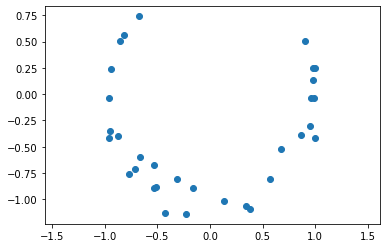

In [4]:
plt.scatter(dataset[:,0],dataset[:,1])
plt.axis("equal")
#plt.plot(np.cos(np.arange(0,100,0.01)),np.sin(np.arange(0,100,0.01)))

# 1D VAE Fit to Dataset

In [5]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device, alldata=False):
    """Sample Pair of Points from Trajectory"""
    if alldata:
        if batchsize is not None:
            raise "don't pass in batchsize if you're doing all data"
        traj_ids = range(all_points.shape[0])
        t1_ids = [0]
        t2_ids = t1_ids
    else:
        # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
        traj_ids = np.random.choice(all_points.shape[0], batchsize)
        t1_ids = np.random.choice(all_points.shape[1], batchsize)
        if predictive:
            t2_ids = np.random.choice(all_points.shape[1], batchsize)
        else:
            t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [6]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cuda"
train_loader = Loader(dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
    

In [7]:
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [8]:
testname = "pedagogical/swiss2d"

In [9]:

colors=["red","yellow","green","orange","black","gray","blue"]

In [10]:
all_models = ["pedagogical/swiss2d_lat1_secreg0_curvreg0_beta0.0001_20220204-172501"]

In [11]:

for modelpath in all_models:
    vae = lm.load_model(modelpath)
    dat = vae.all_emb_layers[0].weight.detach().cpu().numpy()
    print(np.mean(dat),np.max(dat),np.min(dat),np.std(dat))
    dat = vae.all_emb_layers[0].bias.detach().cpu().numpy()
    print(np.mean(dat),np.max(dat),np.min(dat),np.std(dat))

-0.009160771 0.81279063 -0.8121095 0.42611882
0.022890339 0.76136935 -0.7249863 0.41838685


pedagogical/swiss2d_lat1_secreg0_curvreg0_beta0.0001_20220204-172501
FCPassthroughVAE(
  (fcmu): Linear(in_features=1000, out_features=1, bias=True)
  (fclogvar): Linear(in_features=1000, out_features=1, bias=True)
  (all_recon_layers): ModuleList(
    (0): Linear(in_features=1, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=2, bias=True)
  )
  (all_emb_layers): ModuleList(
    (0): Linear(in_features=2, out_features=1000, bias=True)
  )
)


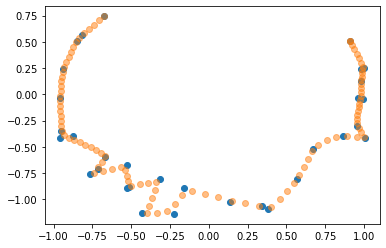

In [12]:
for i, modelpath in enumerate(all_models):
        fig = plt.figure()
        print(modelpath)
        vae = lm.load_model(modelpath)
        print(vae)
        embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                           torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                           )[0].detach().cpu().numpy()
        pts = np.linspace(np.min(embeds[:,0]),np.max(embeds[:,0]),100).reshape((-1,1))
        readout = vae.decode(torch.tensor(pts,dtype=torch.float),
                  torch.tensor(np.zeros((len(pts),0)),dtype=torch.float))[0].detach().cpu()

        plt.scatter(dataset[:,0],dataset[:,1]);
        plt.scatter(readout[:,0],readout[:,1], alpha=0.5);

In [13]:
for _ in range(100):
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0].detach().cpu().numpy()